# Dimuon mass spectrum with RumbleDB on Apache Spark

# Histogram of the Dimuon Mass Spectrum

This implements the dimuon mass spectrum analysis, a "Hello World!" example for data analysis in High Energy Physics. It is intended as a technology demonstrator for the use Apache Spark for High Energy Physics.

The workload and data:
  - The input data is a series of candidate muon events. 
  - The job output is a histogram of the dimuon mass spectrum, where several peaks (resonances) can be identified corresponding to well-know particles (e.g. the Z boson at 91 Gev).
  - The computation is based on https://root.cern.ch/doc/master/df102__NanoAODDimuonAnalysis_8C.html and CERN open data from the CMS collaboration linked there. 
  - See also https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics
  
Author and contact: Luca.Canali@cern.ch  
March, 2022

## Dimuon mass spectrum calculation with Spark DataFrame API

In [ ]:
# Download the data (2 GB) if not yet available locally

! wget https://sparkdltrigger.web.cern.ch/sparkdltrigger/Run2012BC_DoubleMuParked_Muons.parquet

In [5]:
# If needed install or update RumbleDB
# !pip install -U rumbledb

In [1]:
# RumbleDB runs on Spark
# Currently to use RumbleDB on a notebook you need to start RumbleDB on Spark from CLI in serve mode
# See https://rumble.readthedocs.io/en/latest/HTTPServer/
# Note this is base on RumbleDB v1.18 "Scarlet Ixora"

# either run from the CLI or from here
! $SPARK_HOME/bin/spark-submit --driver-memory 4g rumbledb-1.18.0-for-spark-3.2.jar serve -p 8001


In [2]:
# Load the Jupyter notebook extension and configute it

%load_ext rumbledb

# customize the max materialize size
%env RUMBLEDB_SERVER=http://localhost:8001/jsoniq?materialization-cap=31000

env: RUMBLEDB_SERVER=http://localhost:8001/jsoniq?materialization-cap=31000


Check that RumbleDB works in the notebook

In [3]:
%%jsoniq

1+1

Took: 0.34796595573425293 ms
2


In [8]:
data = """
declare function local:histogram($values, $lo, $hi, $num-bins) {
  let $flo := float($lo)
  let $fhi := float($hi)
  let $width := ($fhi - $flo) div float($num-bins)
  let $half-width := $width div 2
  let $offset := $flo mod $half-width

  return
    for $value in $values
    let $truncated-value :=
      if ($value lt $flo) then $flo - $half-width
      else
        if ($value gt $fhi) then $fhi + $half-width
        else $value - $offset
    let $bucket-idx := floor($truncated-value div $width)
    let $center := $bucket-idx * $width + $half-width + $offset

    group by $center
    order by $center
    return {"value": $center, "N_events": count($value)}
};

let $filtered :=
  for $event in parquet-file("Run2012BC_DoubleMuParked_Muons.parquet")
    where $event.nMuon = 2 
          and $event.Muon_charge[[1]] != $event.Muon_charge[[2]]
    let $eta_diff := $event.Muon_eta[[1]] - $event.Muon_eta[[2]]
    let $phi_diff := $event.Muon_phi[[1]] - $event.Muon_phi[[2]]
    let $cosh := (exp($eta_diff) + exp(-$eta_diff)) div 2
    let $invariant-mass :=
      sqrt(2 * $event.Muon_pt[[1]] * $event.Muon_pt[[2]] * ($cosh - cos($phi_diff)))      
  return $invariant-mass

return local:histogram($filtered, 0.25, 300, 30000)
"""

In [9]:
# runs the jsoniq code and collects the results in a histogram

import json
import requests

server = "http://localhost:8001/jsoniq?materialization-cap=31000"

%time histogram = json.loads(requests.post(server, data=data).text)

CPU times: user 75.2 ms, sys: 8.74 ms, total: 84 ms
Wall time: 2min 46s


In [11]:
# Conver the resoults into a Pandas Dataframe

import pandas as pd

histogram_data_pandas = pd.DataFrame(histogram["values"])

In [12]:
histogram_data_pandas

,value,N_events
0,0.245004,377932
1,0.254996,19679
2,0.264987,19285
3,0.274979,18972
4,0.284971,18543
...,...,...
27364,299.915060,1
27365,299.945035,1
27366,299.965018,1
27367,299.985002,2


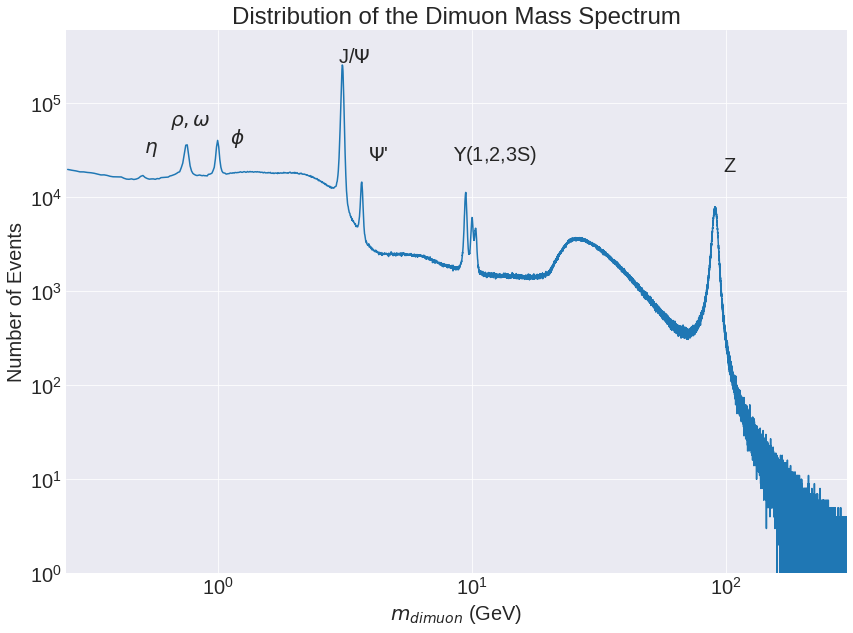

In [13]:
import matplotlib.pyplot as plt 

min_val = 0.25
max_val = 300
num_bins = 30000

plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["N_events"]

# line plot
ax.plot(x, y, '-')

# the plot is in log-log axis to better show the peaks
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(min_val, max_val)
ax.set_ylim(1, 6e5)

ax.set_xlabel('$m_{dimuon}$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of the Dimuon Mass Spectrum")

# Label for the resonances spectrum peaks
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.text(0.85, 0.75, 'Z', **txt_opts)
plt.text(0.55, 0.77, r"$\Upsilon$(1,2,3S)", **txt_opts)
plt.text(0.37, 0.95, r"J/$\Psi$", **txt_opts)
plt.text(0.40, 0.77, r"$\Psi$'", **txt_opts)
plt.text(0.22, 0.80, r"$\phi$", **txt_opts)
plt.text(0.16, 0.83, r"$\rho,\omega$", **txt_opts)
plt.text(0.11, 0.78, r"$\eta$", **txt_opts);

plt.show()